**<h1>Baseline Model Run**

In [30]:
# Library 'datasets' needs to be installed separately while using Google Colab
pip install datasets

In [31]:
# Importing all required libraries
import sys
import gc
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [32]:
# Importing data
with open('data.json') as f:
    data = json.load(f)

In [33]:
# Converting the data into a dataframe and assigning a column name for the text data
df1 = pd.DataFrame(data)
df1 = df1.rename(columns={0: "file"})

In [34]:
# Assigning labels to the data, the first 100 files are AI generated, and the next 100 are human written.
df1 = df1.assign(label=1)
for i in range(100,200):
    df1.label[i] = 0
df = df1.reindex()
df.reset_index(drop=True, inplace=True)

<ipython-input-34-8b827b3576c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.label[i] = 0


In [35]:
# Setting configuration parameters
LOWERCASE = False
VOCAB_SIZE = 30522

In [36]:
# Creating Tokenizer, Normalizing and Pre-Tokenizing
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

In [37]:
# Configuring BPE Trainer
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

In [38]:
# Splitting the dataset into training and testing sets
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
# Training the tokenizer
dataset = Dataset.from_pandas(X_test[['file']])
def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["file"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

In [40]:
# Creating PreTrained Tokenizer object using the trained raw tokenizer
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [41]:
# Tokenizing Testing and Training data
tokenized_texts_test = []
for text in tqdm(X_test['file'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []
for text in tqdm(X_train['file'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [42]:
# TF-IDF Vectorizer Configuration and Fitting on Test Data
def dummy(text):
    return text
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode')
vectorizer.fit(tokenized_texts_test)

TfidfVectorizer(lowercase=False, ngram_range=(3, 5),
                preprocessor=<function dummy at 0x7eb5e4991bd0>,
                strip_accents='unicode', sublinear_tf=True, token_pattern=None,
                tokenizer=<function dummy at 0x7eb5e4991bd0>)

In [43]:
# Getting vocab
vocab = vectorizer.vocabulary_

In [44]:
# Reconfiguring Vectorizer and transforming training dataset, and testing dataset
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

In [45]:
# Deleting the vectorizer
del vectorizer
gc.collect()

8

In [46]:
# Model configuration and training
clf = MultinomialNB(alpha=0.005)
clf.fit(tf_train, y_train)
gc.collect()

0

In [47]:
# Getting and formatiing predictions on test data
final_preds = clf.predict_proba(tf_test)[:, 1]
formatted_values = [f"{val:f}" for val in final_preds]

In [48]:
# Roc Auc Score (Metrics)
roc_auc_score(y_test.to_numpy(), np.array(formatted_values).astype(float))

0.7801932367149759

model 1 AUC score: 0.7801932367149759


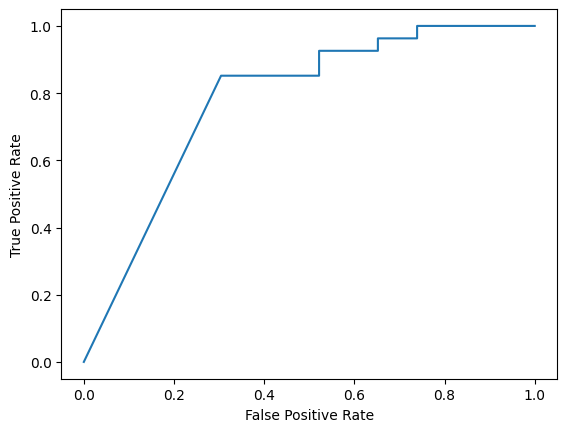

In [49]:
# Plottin the roc curve based of the probabilities
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test.to_numpy(), np.array(formatted_values).astype(float))
print(f'model 1 AUC score: {roc_auc_score(y_test.to_numpy(), np.array(formatted_values).astype(float))}')